In [61]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

## Caso usar o colab

In [62]:
# from google.colab import drive

# drive.mount('/content/drive')
# data_dir = "/content/drive/MyDrive/Meus códigos/data/MyDatas/consumo_televisao.csv"
# print(os.listdir(data_dir))

## Caso usar localmente

In [63]:
data_dir = "./data/After Filters"
print(os.listdir(data_dir))

['gasto_energia_norte.csv', 'gasto_energia_sul.csv']


In [64]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

In [65]:
label_col_index = 0  # consumption as label to predict
inputs_cols_indices = range(5)  # use (consumption, hour, dayofweek, month, dayofyear) columns as features

# Define window_size period and split inputs/labels
window_size = 90

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

# Skipping the files we're not using
processing_files = [file for file in os.listdir(data_dir) if os.path.splitext(file)[1] == ".csv"]

num_files_for_dataset = 5

for file in tqdm_notebook(processing_files[:num_files_for_dataset]):
  print(f"Processing {file} ...")
  # Store csv file in a Pandas DataFrame
  df = pd.read_csv(os.path.join(data_dir, file), parse_dates=["Datetime"])
  print(df)

  # Processing the time data into suitable input formats
  df["hour"] = df.apply(lambda x: x["Datetime"].hour, axis=1)
  df["dayofweek"] = df.apply(lambda x: x["Datetime"].dayofweek, axis=1)
  df["month"] = df.apply(lambda x: x["Datetime"].month, axis=1)
  df["dayofyear"] = df.apply(lambda x: x["Datetime"].dayofyear, axis=1)
  df = df.sort_values("Datetime").drop("Datetime", axis=1)
  # df = df.drop("Time", axis=1)

  # Scaling the input data
  sc = MinMaxScaler()
  label_sc = MinMaxScaler()
  data = sc.fit_transform(df.values)

  # Obtaining the scaler for the labels(usage data) so that output can be
  # re-scaled to actual value during evaluation
  label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
  label_scalers[file] = label_sc

  # Move the window
  inputs, labels = move_sliding_window(
    data,
    window_size,
    inputs_cols_indices=inputs_cols_indices,
    label_col_index=label_col_index,
  )

  # CONCAT created instances from all .csv files.
  # Split data into train/test portions and combining all data from different files into a single array
  test_portion = int(0.1 * len(inputs))
  if len(train_x) == 0:  # first iteration
    train_x = inputs[:-test_portion]
    train_y = labels[:-test_portion]
  else:
    train_x = np.concatenate((train_x, inputs[:-test_portion]))
    train_y = np.concatenate((train_y, labels[:-test_portion]))
  test_x[file] = inputs[-test_portion:]
  test_y[file] = labels[-test_portion:]

  0%|          | 0/2 [00:00<?, ?it/s]

Processing gasto_energia_norte.csv ...
                Datetime    MWh
0    2001-01-01 01:00:00   57.0
1    2001-01-02 01:00:00   60.9
2    2001-01-03 01:00:00   61.0
3    2001-01-04 01:00:00   60.8
4    2001-01-05 01:00:00   61.8
...                  ...    ...
8030 2022-12-27 01:00:00  150.5
8031 2022-12-28 01:00:00  148.2
8032 2022-12-29 01:00:00  148.2
8033 2022-12-30 01:00:00  151.7
8034 2022-12-31 01:00:00  146.2

[8035 rows x 2 columns]
(7945, 90, 5) (7945, 1)
Processing gasto_energia_sul.csv ...
                Datetime    MWh
0    1999-01-01 01:00:00  109.7
1    1999-01-02 01:00:00  118.8
2    1999-01-03 01:00:00  117.3
3    1999-01-04 01:00:00  152.3
4    1999-01-05 01:00:00  153.9
...                  ...    ...
8761 2022-12-27 01:00:00  279.1
8762 2022-12-28 01:00:00  264.9
8763 2022-12-29 01:00:00  255.6
8764 2022-12-30 01:00:00  257.3
8765 2022-12-31 01:00:00  245.7

[8766 rows x 2 columns]
(8676, 90, 5) (8676, 1)


In [66]:
batch_size = 1024

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Drop the last incomplete batch
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [67]:
print(f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}")

Train Size: (14960, 90, 5), Batch Size: 1024, # of iterations per epoch: 14


In [68]:
# release some memory
del train_x, train_y

In [69]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("CPU is available")

CPU is available


In [70]:
class GRUNet(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
    super(GRUNet, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.gru = nn.GRU(
      input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
    )
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x, h):
    out, h = self.gru(x, h)
    # print(out[:, -1].shape, h.shape)
    # select hidden state of last timestamp (t=90) (1024, 256)
    out = self.fc(self.relu(out[:, -1]))  # out[:, -1, :]
    # print(out.shape) # (1024, 1)
    return out, h

  def init_hidden(self, batch_size):
    # Initialze h_0 with zeros
    weight = next(self.parameters()).data
    hidden = (
        weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
    )
    return hidden


class LSTMNet(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
    super(LSTMNet, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x, h):
    out, h = self.lstm(x, h)
    out = self.fc(self.relu(out[:, -1]))
    return out, h

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    # Initialze h_0, c_0 with zeros
    hidden = (
      weight.new(self.n_layers, batch_size, self.hidden_dim)
      .zero_()
      .to(device),  # h_0
      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
    )
    return hidden

In [71]:
def train(
  train_loader,
  learn_rate,
  hidden_dim=256,
  n_layers=2,
  n_epochs=5,
  model_type="GRU",
  print_every=100,
):

  input_dim = next(iter(train_loader))[0].shape[2]  # 5

  # Batch generator (train_data, train_label)
  # print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape) # torch.Size([1024, 90, 5]) torch.Size([1024, 1])

  output_dim = 1

  # Instantiating the models
  if model_type == "GRU":
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
  else:
    model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
  model.to(device)

  # Defining loss function and optimizer
  criterion = nn.MSELoss()  # Mean Squared Error
  optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

  model.train()
  print("Starting Training of {} model".format(model_type))
  epoch_times = []

  # Start training loop
  for epoch in range(1, n_epochs + 1):
    start_time = time.process_time()
    h = model.init_hidden(batch_size)
    avg_loss = 0.0
    counter = 0
    for x, label in train_loader:
      counter += 1
      if model_type == "GRU":
        h = h.data
      # Unpcak both h_0 and c_0
      elif model_type == "LSTM":
        h = tuple([e.data for e in h])

      # Set the gradients to zero before starting to do backpropragation because
      # PyTorch accumulates the gradients on subsequent backward passes
      model.zero_grad()

      out, h = model(x.to(device).float(), h)
      loss = criterion(out, label.to(device).float())

      # Perform backpropragation
      loss.backward()
      optimizer.step()

      avg_loss += loss.item()
      if counter % print_every == 0:
        print(f"Epoch {epoch} - Step: {counter}/{len(train_loader)} - Average Loss for Epoch: {avg_loss/counter}")
    current_time = time.process_time()

    print(f"Epoch {epoch}/{n_epochs} Done, Total Loss: {avg_loss/len(train_loader)}")

    print(f"Time Elapsed for Epoch: {current_time-start_time} seconds")

    epoch_times.append(current_time - start_time)

  print(f"Total Training Time: {sum(epoch_times)} seconds")
  return model

In [72]:
# seq_len = 90  # (timestamps)
n_hidden = 256
n_layers = 2
n_epochs = 4
print_every = 5
lr = 0.001

In [73]:
gru_model = train(
  train_loader,
  learn_rate=lr,
  hidden_dim=n_hidden,
  n_layers=n_layers,
  n_epochs=n_epochs,
  model_type="GRU",
  print_every=print_every,
)

Starting Training of GRU model
Epoch 1 - Step: 5/14 - Average Loss for Epoch: nan
Epoch 1 - Step: 10/14 - Average Loss for Epoch: nan
Epoch 1/4 Done, Total Loss: nan
Time Elapsed for Epoch: 143.4375 seconds
Epoch 2 - Step: 5/14 - Average Loss for Epoch: nan
Epoch 2 - Step: 10/14 - Average Loss for Epoch: nan
Epoch 2/4 Done, Total Loss: nan
Time Elapsed for Epoch: 125.09375 seconds
Epoch 3 - Step: 5/14 - Average Loss for Epoch: nan
Epoch 3 - Step: 10/14 - Average Loss for Epoch: nan
Epoch 3/4 Done, Total Loss: nan
Time Elapsed for Epoch: 124.359375 seconds
Epoch 4 - Step: 5/14 - Average Loss for Epoch: nan
Epoch 4 - Step: 10/14 - Average Loss for Epoch: nan
Epoch 4/4 Done, Total Loss: nan
Time Elapsed for Epoch: 129.328125 seconds
Total Training Time: 522.21875 seconds


## Caso usar o colab

In [74]:
#torch.save(gru_model.state_dict(), "/content/drive/MyDrive/Meus códigos/models/MyDatas/gru_model.pt")

## Caso usar localmente

In [75]:
torch.save(gru_model.state_dict(), "./models/gru_model.pt")

In [76]:
lstm_model = train(
  train_loader,
  learn_rate=lr,
  hidden_dim=n_hidden,
  n_layers=n_layers,
  n_epochs=n_epochs,
  model_type="LSTM",
  print_every=print_every,
)

Starting Training of LSTM model
Epoch 1 - Step: 5/14 - Average Loss for Epoch: nan
Epoch 1 - Step: 10/14 - Average Loss for Epoch: nan
Epoch 1/4 Done, Total Loss: nan
Time Elapsed for Epoch: 106.296875 seconds
Epoch 2 - Step: 5/14 - Average Loss for Epoch: nan
Epoch 2 - Step: 10/14 - Average Loss for Epoch: nan
Epoch 2/4 Done, Total Loss: nan
Time Elapsed for Epoch: 111.5625 seconds
Epoch 3 - Step: 5/14 - Average Loss for Epoch: nan
Epoch 3 - Step: 10/14 - Average Loss for Epoch: nan
Epoch 3/4 Done, Total Loss: nan
Time Elapsed for Epoch: 109.046875 seconds
Epoch 4 - Step: 5/14 - Average Loss for Epoch: nan
Epoch 4 - Step: 10/14 - Average Loss for Epoch: nan
Epoch 4/4 Done, Total Loss: nan
Time Elapsed for Epoch: 106.3125 seconds
Total Training Time: 433.21875 seconds


## Caso usar o colab

In [77]:
#torch.save(gru_model.state_dict(), "/content/drive/MyDrive/Meus códigos/models/MyDatas/lstm_model.pt")

## Caso usar localmente

In [78]:
torch.save(lstm_model.state_dict(), "./models/lstm_model.pt")

In [79]:
# move device to cpu for evaluation to avoid GPU memory run
device = "cpu"

In [80]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
gru_model.load_state_dict(torch.load("./models/gru_model.pt"))

<All keys matched successfully>

In [81]:
# Move the model to the appropriate device
gru_model.to(device)

GRUNet(
  (gru): GRU(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [82]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("./models/lstm_model.pt"))

<All keys matched successfully>

In [83]:
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [84]:
def sMAPE(outputs, targets):
  sMAPE = (
    100
    / len(targets)
    * np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2)
  )
  return sMAPE

In [85]:
def evaluate(model, test_x, test_y, label_scalers):
  model.eval()
  outputs = []
  targets = []
  start_time = time.process_time()
  # get data of test data for each state
  for file in test_x.keys():
    inputs = torch.from_numpy(np.array(test_x[file]))
    labels = torch.from_numpy(np.array(test_y[file]))

    h = model.init_hidden(inputs.shape[0])

    # predict outputs
    with torch.no_grad():
      out, h = model(inputs.to(device).float(), h)

    outputs.append(
      label_scalers[file]
      .inverse_transform(out.cpu().detach().numpy())
      .reshape(-1)
    )

    targets.append(label_scalers[file].inverse_transform(labels.numpy()).reshape(-1))

  # Merge all files
  concatenated_outputs = np.concatenate(outputs)
  concatenated_targets = np.concatenate(targets)

  print(f"Evaluation Time: {time.process_time()-start_time}")
  print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")

  # list of of targets/outputs for each state
  return outputs, targets, sMAPE

In [86]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

Evaluation Time: 3.828125
sMAPE: nan%


In [87]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 2.953125
sMAPE: nan%


In [88]:
len(gru_outputs)  # list of predicted output file for each state (each element has a 1d array for that state)

2

In [89]:
states_list = list(test_x.keys())

### Alguns métodos explicados
1) *`gca()`* é uma abreviação de "get current axes" (obter eixos atuais)

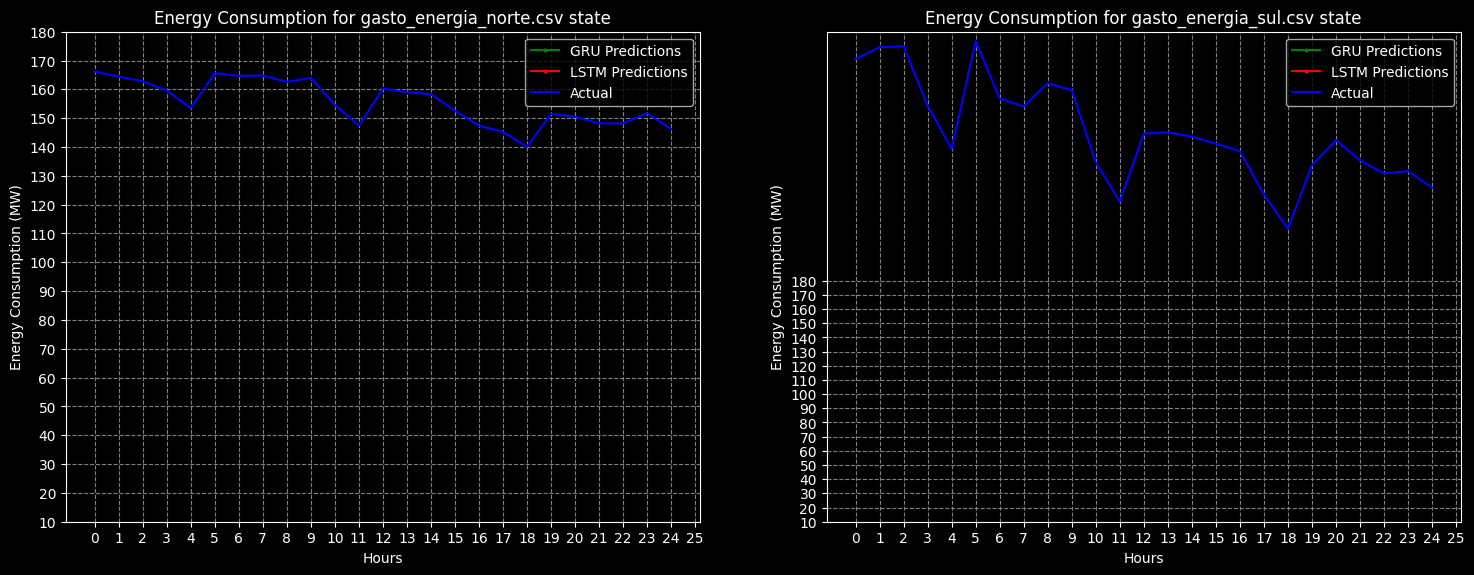

In [90]:
import matplotlib.pyplot as plt

rangeAxisX = 25

plt.figure(figsize=(18, 14))
plt.subplot(2, 2, 1)

outputGRU = gru_outputs[0][-rangeAxisX:]

#* Output 1
plt.plot(outputGRU, "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[0][-rangeAxisX:], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[0][-rangeAxisX:], color="b", label="Actual")

plt.yticks(np.arange(10, 180 + 1, 10))
plt.xticks(np.arange(0, rangeAxisX + 1, 1))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)

plt.legend()

# Unidade de medida dos eixos
plt.ylabel("Energy Consumption (MW)")
plt.xlabel("Hours")  # Eu, Pedro Luis, criei isso pra por no artigo
plt.title(f"Energy Consumption for {states_list[0]} state")

plt.yticks(np.arange(10, 180 + 1, 10))
plt.xticks(np.arange(0, rangeAxisX + 1, 1))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)

plt.legend()

#* Output 2
plt.subplot(2, 2, 2)
plt.plot(gru_outputs[1][-rangeAxisX:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[1][-rangeAxisX:], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[1][-rangeAxisX:], color="b", label="Actual")

plt.ylabel("Energy Consumption (MW)")
plt.xlabel("Hours")  # 
plt.title(f"Energy Consumption for {states_list[1]} state")

plt.yticks(np.arange(10, 180 + 1, 10))
plt.xticks(np.arange(0, rangeAxisX + 1, 1))
plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)

plt.legend()

# Personalizar a cor da grade, peguei do gpt, n sei como funciona
# plt.gca().yaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
# plt.gca().xaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.8)
# plt.grid(True, color='gray', linestyle='dashed', linewidth=0.8)

# Mostra o gráfico
plt.show()